In [1]:
import os
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

### Initialise the environment

In [2]:
p1 = 0.80 # true expected payoff for arm 1
p2 = 0.50 # true expected payoff for arm 2

arms = [p1, p2]

### Initialise the agent

In [3]:
a = np.array([1, 4])
np.array(a >= a.max()).astype(int)

array([0, 1])

In [4]:
def policy(q_values, temp=None, type='softmax'):

    if temp:
        t = temp
    else:
        t = 1
    if type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    else:
        return np.array(q_values >= q_values.max()).astype(int)

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

gamma   = 0.9
gittins = np.genfromtxt('../gittins200_gamma09.csv', delimiter=',') # load gittins indices
gittins = gittins[1:, 1:] # remove (0, .) and (., 0) priors

# initial belief state
M = np.array([
    [1, 1],
    [1, 1]
], dtype=int)

temp = 1 # inverse temperature for softmax

### Run the model-free agent

In [5]:
np.random.seed(1234)

num_episodes = 180
for ep in range(num_episodes):
    Q  = np.array([gittins[M[0, 0], M[0, 1]], gittins[M[1, 0], M[1, 1]]])
    # a = np.argmax(Q)
    ps = policy(Q, temp=temp)
    a  = np.random.choice([0, 1], p=ps)
    r  = np.random.choice([0, 1], p=(1-arms[a], arms[a]))
    M  = belief_update(M, a, r)

### Plot the resulting belief

Text(0.5, 1.0, '$\\mathbb{E}[p\\mid b]$')

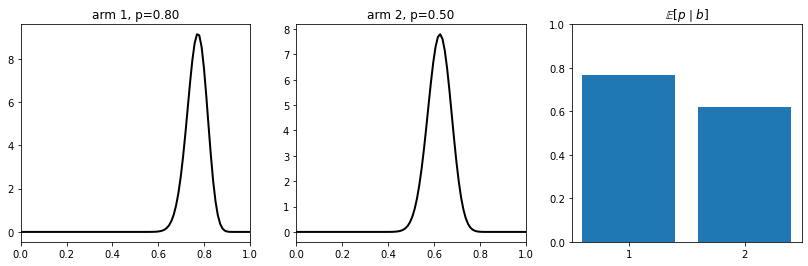

In [6]:
plt.figure(figsize=(14, 4))

x = np.linspace(0, 1, 100)
plt.subplot(1, 3, 1)
a, b = M[0, 0], M[0, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 1, p=%.2f'%arms[0])
plt.subplot(1, 3, 2)
a, b = M[1, 0], M[1, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 2, p=%.2f'%arms[1])
plt.subplot(1, 3, 3)
plt.bar([1, 2], [M[0, 0]/np.sum(M[0, :]), M[1, 0]/np.sum(M[1, :])])
plt.xticks([1, 2], [1, 2])
plt.ylim(0,1)
plt.title(r'$\mathbb{E}[p\mid b]$')

In [7]:
M

array([[72, 22],
       [56, 34]])

### Construct belief tree

In [93]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0, 0)] = b
    tree[0][(1, 1)] = b

    for hi in range(1, h):
        c = 0
        for k, v in tree[hi-1].items():
            
            prev_c = k[-1]
            prev_a = k[0]
            
            for r in [0, 1]:
                
                b1 = belief_update(v, prev_a, r)

                for a in range(2):
                    tree[hi][(a, prev_c, c)] = b1
                    c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
    v(ba^*)-v(b) =& \mathbb{E}_{b'\sim p(b'\mid b, a^*)}\Big[\sum_a \big(\pi(a\mid b')-\pi(a\mid b)\big)q(b',a) \\
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[r(b',a) - r(b,a)\big]  \\ 
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[\gamma \sum_{b''}p(b''\mid b', a)v(b'') - \gamma \sum_{g'}p(g'\mid b, a)v(g') \big] \Big] 
\end{align*}
$$

where $ba^*$ is a belief that results from choosing action $a^*$ from belief $b$, the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [139]:
def evb(tree):
    '''
    calculate the evb for all tree nodes
    -------
    tree: belief tree
    -------
    '''

    h        = len(tree.keys()) # planning horizon
    evb_tree = {hi:{} for hi in range(h)} # tree with evb values for each node
    val_tree = {hi:{} for hi in range(h)} # tree with value functions for each node

    # first assign leaf values as immediate reward at all horizons
    for hi in range(h):
        for k, b in tree[hi].items():
            q_values        = np.array([b[0, 0]/np.sum(b[0, :]), b[1, 0]/np.sum(b[1, :])]) # initial q-values are just the immediate reward
            val_tree[hi][k] = np.dot(policy(q_values), q_values) # change temperature?

    # then compute evb for every backup 
    for hi in reversed(range(h-1)):
        for k, b in tree[hi].items():

            arm      = k[0]
            v        = val_tree[hi][k] # current value of this belief state
            c        = k[-1]
            v_primes = []
            b_primes = []

            for k1, b_prime in tree[hi+1].items():
                prev_c = k1[-2]
                if prev_c == c:
                    v_primes += [val_tree[hi+1][k1]] # values of next belief states
                    b_primes += [b_prime]

            evb_out = 0
            for idx, v_prime in enumerate(v_primes):
                b_prime = b_primes[idx]

                if b_prime[arm, 0] > b[arm, 0]:
                    evb_out += (b[arm, 0]/np.sum(b[arm, :]))*(v_prime - v)
                else:
                    evb_out += (b[arm, 1]/np.sum(b[arm, :]))*(v_prime - v)

            evb_tree[hi][(arm, c)] = evb_out

    updates = {hi:[] for hi in range(h-1)}
    for hi in reversed(range(h-1)):
        max_val = 0
        for k, v in evb_tree[hi].items():
            if v > max_val:
                updates[hi] = [k[0], v]
                max_val     = v

    return evb_tree

In [140]:
h    = 6
tree = get_belief_tree(h, M)

In [141]:
evb_tree = evb(tree)

In [144]:
evb_tree[2]

{(0, 0): 9.884986667429985e-06,
 (1, 1): 1.407579013169933e-05,
 (0, 2): 9.591652548099523e-06,
 (1, 3): 1.4056173724075194e-05,
 (0, 4): 9.85688471931423e-06,
 (1, 5): 1.3838996112078197e-05,
 (0, 6): 9.871542805831805e-06,
 (1, 7): 1.3704260323259276e-05,
 (0, 8): 9.591652548099523e-06,
 (1, 9): 1.4056173724075194e-05,
 (0, 10): 9.286692284010342e-06,
 (1, 11): 1.4035061630140143e-05,
 (0, 12): 9.544700733201718e-06,
 (1, 13): 1.3817364494265235e-05,
 (0, 14): 9.559992701648444e-06,
 (1, 15): 1.3684410724645185e-05,
 (0, 16): 9.85688471931423e-06,
 (1, 17): 1.3838996112078197e-05,
 (0, 18): 9.544700733201718e-06,
 (1, 19): 1.3817364494265235e-05,
 (0, 20): 9.812452358506658e-06,
 (1, 21): 1.35986015792444e-05,
 (0, 22): 9.82845982297649e-06,
 (1, 23): 1.3479135270499931e-05,
 (0, 24): 9.871542805831805e-06,
 (1, 25): 1.3704260323259276e-05,
 (0, 26): 9.559992701648444e-06,
 (1, 27): 1.3684410724645185e-05,
 (0, 28): 9.82845982297649e-06,
 (1, 29): 1.3479135270499931e-05,
 (0, 30): 9.

### Check updates with the highest evb

In [145]:
updates = {hi:[] for hi in range(h-1)}
for hi in reversed(range(h-1)):
    max_val = 0
    for k, v in evb_tree[hi].items():
        if v > max_val:
            updates[hi] = [k[0], v]
            max_val     = v

In [146]:
updates

{0: [1, 1.4045129664373712e-05],
 1: [1, 1.406106042999922e-05],
 2: [1, 1.407579013169933e-05],
 3: [1, 1.408937986852694e-05],
 4: [1, 1.4101887527455045e-05]}

### Analyse the evb curve

In [108]:
def evb_matrix(arm, alphab, betab):
    x, y   = 50, 50
    alphas = np.arange(1, x)
    betas  = np.arange(1, y)
    evb_plot = np.zeros((x, y))

    for x in alphas:
        for y in betas:
            m = np.array([
                [x, y],
                [alphab, betab]
            ], dtype=int)
            m_primes = [m.copy(), m.copy()]
            m_primes[0][arm, 0] += 1
            m_primes[1][arm, 1] += 1

            tmp = evb(m, arm, m_primes)
            evb_plot[x, y] = tmp

    return evb_plot

In [82]:
alphab, betab = 1, 1

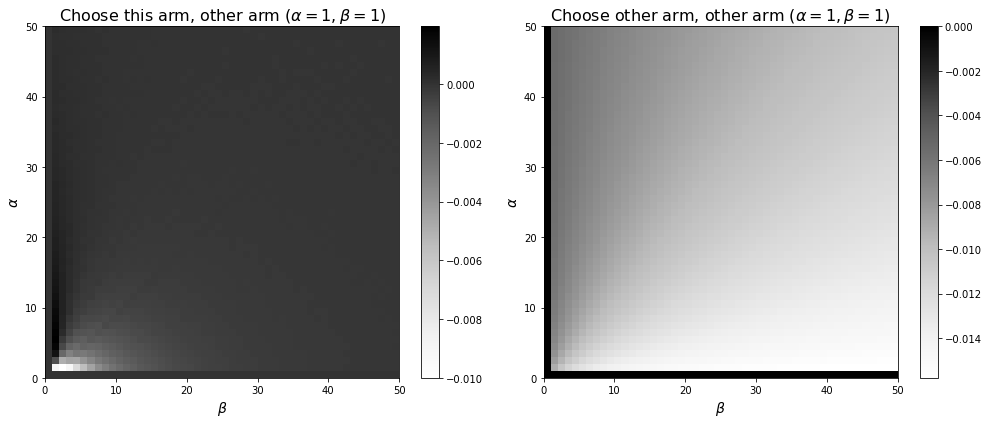

In [83]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
evb_plot = evb_matrix(0, alphab, betab)
plt.pcolormesh(evb_plot, cmap='Greys')
plt.colorbar()
plt.title('Choose this arm' + ', other arm ' + r'$(\alpha=%u, \beta=%u)$'%(alphab, betab), fontsize=16)
plt.ylabel(r'$\alpha$', fontsize=14)
plt.xlabel(r'$\beta$', fontsize=14)

plt.subplot(1, 2, 2)
evb_plot = evb_matrix(1, alphab, betab)
plt.pcolormesh(evb_plot, cmap='Greys')
plt.colorbar()
plt.title('Choose other arm' + ', other arm ' + r'$(\alpha=%u, \beta=%u)$'%(alphab, betab), fontsize=16)
plt.ylabel(r'$\alpha$', fontsize=14)
plt.xlabel(r'$\beta$', fontsize=14)
plt.tight_layout()